# Grafos de fluxos

Na sua versão mais simples, um *grafo de fluxos* é um grafo orientado onde cada aresta modela uma "conduta" onde pode fluir "alguma coisa" (gás, água, trânsito automóvel, etc) sujeita a uma capacidade máxima. Mais em informação em https://en.wikipedia.org/wiki/Flow_network.

Usando o `networkx` podemos modelar um grafo de fluxos usando um `DiGraph` (*directed graph*), usando atributos adicionais para representar a capacidade máxima de cada arco e o respectivo fluxo efectivo. Por exemplo, o seguinte código cria um grafo de fluxos com 6 nodos e 10 arcos.

In [ ]:
import networkx as nx

graph = nx.DiGraph()
graph.add_edge(0,1,capacity=16)
graph.add_edge(0,2,capacity=13)
graph.add_edge(1,2,capacity=10)
graph.add_edge(1,3,capacity=12)
graph.add_edge(2,1,capacity=4)
graph.add_edge(2,4,capacity=14)
graph.add_edge(3,2,capacity=9)
graph.add_edge(3,5,capacity=20)
graph.add_edge(4,3,capacity=7)
graph.add_edge(4,5,capacity=4)

Podemos desenhar este grafo de fluxos usando a seguinte função que assume que o grafo é planar e que coloca como fluxo efectivo o caracter `?` caso este atributo não esteja definido.

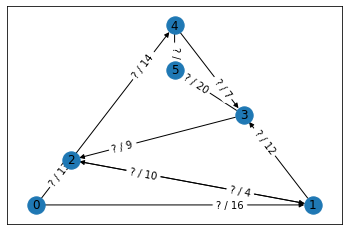

In [ ]:
def draw_flow_network(graph):
    pos = nx.planar_layout(graph)
    labels = {}
    for (o,d) in graph.edges():
        if 'flow' in graph[o][d]:
            labels[(o,d)] = str(graph[o][d]['flow']) + ' / ' + str(graph[o][d]['capacity'])
        else:
            labels[(o,d)] = '? / ' + str(graph[o][d]['capacity'])                        
    nx.draw_networkx(graph,pos)
    nx.draw_networkx_edge_labels(graph,pos,labels,label_pos=0.3)


draw_flow_network(graph)

## Max-flow

Um dos problemas clássicos com grafos de fluxos consiste em determinar qual o fluxo máximo que pode existir entre dois nodos concretos do grafo.

Usando programação inteira mista (com variáveis inteiras e reais) podemos determinar este fluxo máximo da seguinte forma.

Mais uma vez usaremos a biblioteca [OR-Tools](https://developers.google.com/optimization) para fazer a interface para o SCIP. Esta biblioteca pode ser instalada com o commando `pip install ortools`.

In [ ]:
!pip install ortools

     |████████████████████████████████| 14.5 MB 92 kB/s 
     |████████████████████████████████| 1.1 MB 60.6 MB/s 
     |████████████████████████████████| 132 kB 79.9 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 0.12.0
    Uninstalling absl-py-0.12.0:
      Successfully uninstalled absl-py-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.2.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.


### Análise do problema

Dado um grafo orientado $(V,E)$, uma capacidade $C_e \ge 0$ para cada arco $e \in E$, um nodo $s$ correspondente à origem e um nodo $t$ correspondente ao destino, precisamos de uma variável $f_e$ do tipo real por cada arco $e \in E$, que irá representar o fluxo efectivo nesse arco. Para encontrar o fluxo máximo entre $s$ e $t$ basta maximizar

$$
\sum_{(s,v) \in E} f_{(s,v)} - \sum_{(v,s) \in E} f_{(v,s)}
$$

ou seja, a soma do fluxos efectivos com origem em $s$ (alternativamente, poderia-se maximizar a soma dos fluxos efectivos com destino $t$), sujeito às seguintes restrições:
- A capacidade de cada arco é respeitada
- O fluxo que sai de cada nodo é igual ao que entra (exceptuando em $s$ e $t$)

### Exercício 1

Formalize estas restrições.


$ 1. \quad \forall_{e\in E} \quad f_{e}\leq C_{e} $

$ 2. \quad \forall_{v\in V \setminus \{s,t\}} \quad \sum_{(v,x)\in E} f_{(v,x)} = \sum_{(x,v)\in E} f_{(x,v)} $

### Exercício 2

Implemente a função `max_flow` que dado um grafo de fluxos, determina o fluxo máximo entre `s` e `t`, definindo também o atributo `flow` com o fluxo efectivo de cada arco necessário para atingir esse fluxo máximo. Em `networkx` pode usar o método `edges` para aceder aos arcos de um grafo, e os métodos `in_edges` e `out_edges` para aceder aos arcos de entrada e saída de um determinado vértice.

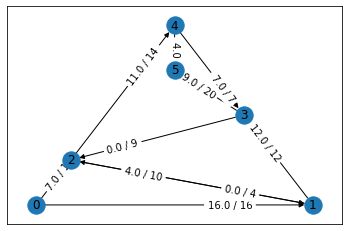

In [ ]:
from ortools.linear_solver import pywraplp

def max_flow(graph,s,t):
  sol = pywraplp.Solver.CreateSolver('SCIP')
    
  f = {}
  for (o,d) in graph.edges():
    f[(o,d)] = sol.NumVar(0, graph[o][d]['capacity'],'f[%i, %i]' % (o,d)) # Como ja esta limitada, ja inclui restrição 1.

  for v in graph.nodes():
    if v != s and v != t:
      sol.Add(sum([f[e] for e in graph.out_edges(v)]) == sum([f[e] for e in graph.in_edges(v)])) # Restrição 2

  sol.Maximize(sum([f[e] for e in graph.out_edges(s)]) - sum([f[e] for e in graph.in_edges(s)]))

  if sol.Solve() == pywraplp.Solver.OPTIMAL:
    x = sol.Objective().Value()
    for (o,d) in graph.edges():
      graph[o][d]['flow'] = f[(o,d)].solution_value()
    return x

  return -1


assert max_flow(graph,0,5) == 23
draw_flow_network(graph)

## Min-cut

Um dos resultados fundamentais sobre grafos de fluxos, conforme https://en.wikipedia.org/wiki/Max-flow_min-cut_theorem, diz que o fluxo máximo entre dois vértices é igual à soma da capacidade dos arcos que estabelecem um *corte mínimo* entre esses vértices. Num grafo um *corte mínimo* é um conjunto de arcos que divide os nodos em dois conjuntos disjuntos satisfazendo algum critério de minimalidade. Neste caso estamos interessados em dividir o grafo em dois conjuntos $S$ e $T$ onde a origem $s \in S$ e o destino $t \in T$, minimizando a capacidade total dos arcos que pertecem ao corte, ou seja, a capacidade total dos arcos que ligam $S$ a $T$.

### Análise do problema

Dado um grafo orientado $(V,E)$, uma capacidade $C_e \ge 0$ para cada arco $e \in E$, um nodo $s$ correspondente à origem e um nodo $t$ correspondente ao destino, precisamos de uma variável binária $d_{(a,b)}$ por cada aresta $(a,b) \in E$, que terá o valor 1 se a respectiva aresta pertencer ao corte entre $S$ e $T$ (ou seja, se $a \in S$ e $b \in T$), e de uma variável binária $x_v$ por cada vértice $v \in V$, que terá o valor 1 se o respectivo vértice pertencer a $S$ (se o valor for 0 é porque $v \in T$). Para encontrar o corte mínimo basta minimizar

$$
\sum_{e \in E} d_{e} \cdot C_e
$$

sujeito às seguintes restrições:
- O nodo $s$ pertence a $S$ e o nodo $t$ pertence a $T$
- Uma aresta com origem em $S$ e destino em $T$ pertence ao corte

### Exercício 3

Formalize estas restrições.

$ 1. \quad x_{s} = 1 \quad \wedge\quad x_{t} = 0 $

$ 2. \quad \forall_{(a,b)\in E}\quad d_{(a,b)} \leq x_{a} - x_{b} $

### Exercício 4

Implemente a função `min_cut` que dado um grafo de fluxos determina o fluxo máximo entre `s` e `t`.

In [ ]:
def min_cut(graph,s,t):
    sol = pywraplp.Solver.CreateSolver('SCIP')
    
    x = {}
    for v in graph:
      x[v] = sol.BoolVar(str(v))

    d = {}
    for e in graph.edges():
      d[e] = sol.BoolVar(str(e))

    sol.Add(x[s] == 1)
    sol.Add(x[t] == 0)

    for (a,b) in graph.edges():
      sol.Add(d[(a,b)] >= x[a] - x[b])

    sol.Minimize(sum( [d[(o,p)] * graph[o][p]['capacity'] for (o,p) in graph.edges()] ))
    
    if sol.Solve() == pywraplp.Solver.OPTIMAL:
      x = sol.Objective().Value()
      return x

assert min_cut(graph,0,5) == 23

## Outros problemas de corte mínimo

Outro problema relacionado com o corte mínimo consiste em determinar, para um grafo orientado e dois nodos $s$ e $t$ desse grafo, o número mínimo de arcos que é necessário retirar para que $t$ deixe de ser acessível a partir de $s$.

Uma forma directa de resolver este problema consiste em começar por determinar todos os caminhos (sem ciclos) entre $s$ e $t$ e depois determinar o conjunto mínimo de arestas que intersecta todos esses caminhos.

### Exercício 5

Formalize este problema usando programação inteira. Assuma que dado um grafo $(V,E)$ e os nodos $s$ e $t$, $P$ é o conjunto de todos os caminhos (sem ciclos) entre $s$ e $t$, onde cada caminho é representado pelo conjunto dos arcos que lhe pertencem.

* $d_{e} = 1$  se a aresta $e$ está no corte
* Objetivo: Minimizar $\sum_{e\in E} d_{e}$
* Restrições:

  1. $\forall_{p\in P} \sum_{e\in p}d_{e} \geq 1 $

### Exercício 6

Implemente a função `disconnect_all_paths` que dado um grafo `graph` e os nodos `s` e `t` devolve a lista de arestas a remover para que `t` deixe de ser acessível a partir de `s`. Pode usar a função `all_simple_paths` do `networkx` para determinar todos os caminhos sem ciclos entre dois vértices.

In [ ]:
def disconnect_all_paths(graph,s,t):
  sol = pywraplp.Solver.CreateSolver('SCIP')
  # completar
  d = {}
  for e in graph.edges():
    d[e] = sol.BoolVar(str(e))

  for p in nx.all_simple_paths(graph, s, t):
    sol.Add(sum([d[e] for e in path_edges(p)]))

  sol.Minimize(sum( [list(d.values())] ))
  lista = []
  if sol.Solve() == pywraplp.Solver.OPTIMAL:
    for x in graph.edges():
      if d[x].solution_value() == 1:
        lista.append(x)
  return lista

disconnect_all_paths(graph,0,5)

### Exercício 7

Também é possível reduzir este problema ao problema do corte mínimo em grafos de fluxos assumindo simplesmente que a capacidade  dos arcos é 1.

Implemente a função `disconnect_min_cut` que dado um grafo `graph` e os nodos `s` e `t` devolve a lista de arestas a remover para que `t` deixe de ser acessível a partir de `s` usando esta técnica.

In [ ]:
def disconnect_min_cut(graph,s,t):
    sol = pywraplp.Solver.CreateSolver('SCIP')
    # completar

    
disconnect_min_cut(graph,0,5)

### Exercício 8

Usando análise empírica da complexidade, compare a eficiência destas duas técnicas.

In [ ]:
from timeit import timeit